In [61]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import shap
import xgboost

In [82]:
import jax
from jax import numpy as jnp

ModuleNotFoundError: No module named 'jax'

# Dataset

In [3]:
original_adata = ad.read_h5ad('/Users/davidchen/Documents/Dick Lab/AML Markers/aml_pm_marker.h5ad')

In [4]:
exp_matrix = pd.read_csv('/Users/davidchen/Documents/Dick Lab/AML Markers/Data/AML_raw_gene_expression.csv', index_col=0)


In [5]:
label = list(original_adata.obs['Lineage'])
batch = list(original_adata.obs['Study'])

In [6]:
pm_annot = pd.read_csv('/Users/davidchen/Documents/Dick Lab/AML Markers/Human_Protein_Atlas_Subcellular_Localization.tsv',
                      sep='\t')

In [7]:
exp_matrix = exp_matrix.loc[list(set(exp_matrix.index) & set(pm_annot[pm_annot['Main location'].str.contains('Plasma membrane', na=False)]['Gene name']))]
exp_matrix = exp_matrix[original_adata.obs.index].copy()

In [8]:
adata = ad.AnnData(exp_matrix.T)
adata.obs = original_adata.obs
adata.X = adata.X.astype(int)

In [9]:
def obs_key_wise_subsampling(adata, obs_key, N):
    '''
    Subsample each class to same cell numbers (N). Classes are given by obs_key pointing to categorical in adata.obs.
    '''
    counts = adata.obs[obs_key].value_counts()
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N, replace=False) for group in counts.index]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [10]:
adata = obs_key_wise_subsampling(adata, 'Lineage', 10)

# Visualization: Expression across Lineage

In [12]:
def lineage_gex(adata, gene, lineage, log=True):

    plot_df = pd.DataFrame(adata.to_df()[gene])

    plot_df['Lineage'] = adata.obs['Lineage']

    order = plot_df.groupby('Lineage')[gene].mean().sort_values(ascending=False).index

    fig, ax = plt.subplots(1,1,figsize=(10,5))
    sns.boxplot(data = plot_df,
                  x = 'Lineage',
                  y = gene,
                   palette='Blues_r',
                  ax=ax,
               order=order,
               fliersize=5,
               linewidth=1,
               flierprops={"marker": "."})

    ax.set_ylabel('Normalized Gene\nExpression', size=20)
    ax.set_xlabel('Lineage', size=20)
    ax.set_title(gene, size=20)

    ax.set_xticklabels([x.replace("_", "-") for x in order], size=15, ha='right')

    ax.tick_params('x', rotation=45)
    ax.tick_params('both', length=5, width=1, labelsize=15)

    [x.set_linewidth(1) for x in ax.spines.values()]
    ax.spines[['right', 'top']].set_visible(False)
    
    if log is True:
        ax.set_yscale('log')

    plt.show()

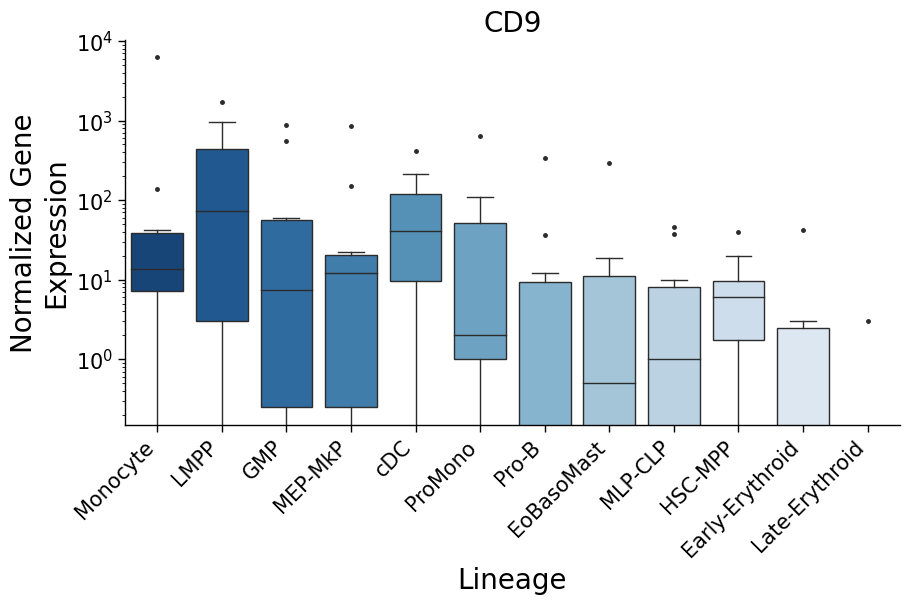

In [50]:
lineage_gex(adata = adata, gene='CD9', lineage='Lineage')

In [18]:
def pca_plot_lineage(adata, lineage, batch=None):
    
    if batch != None:
        sc.pp.combat(adata, key=batch, inplace=True)

    sc.tl.pca(adata, svd_solver='arpack')

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sc.pl.pca(adata, color=lineage, add_outline=False,
                   legend_fontsize=12, legend_fontoutline=2,frameon=False,
                    cmap='jet', ax=ax)

   

In [15]:
def umap_plot_lineage(adata, lineage, batch=None):
    
    if batch != None:
        sc.pp.combat(adata, key=batch, inplace=True)

    sc.tl.pca(adata, svd_solver='arpack')
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    
    sc.tl.umap(adata)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sc.pl.umap(adata, color=lineage, add_outline=False,
                   legend_fontsize=12, legend_fontoutline=2,frameon=False,
                    cmap='jet', ax=ax)

   

In [16]:
def pca_plot_marker(adata, marker, batch=None):
    
    if batch != None:
        sc.pp.combat(adata, key=batch, inplace=True)
        
    sc.tl.pca(adata, svd_solver='arpack')

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sc.pl.pca(adata, color=marker, add_outline=False,
                   legend_fontsize=12, legend_fontoutline=2,frameon=False,
                    cmap='Greens', ax=ax)

   

In [17]:
def umap_plot_marker(adata, marker, batch=None):
    
    if batch != None:
        sc.pp.combat(adata, key=batch, inplace=True)

    sc.tl.pca(adata, svd_solver='arpack')
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    
    sc.tl.umap(adata)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sc.pl.umap(adata, color=marker, add_outline=False,
                   legend_fontsize=12, legend_fontoutline=2,frameon=False,
                    cmap='Greens', ax=ax)

   

/Users/davidchen/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


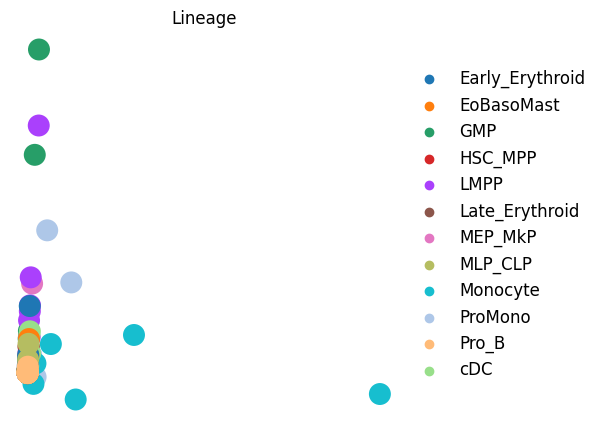

In [19]:
pca_plot_lineage(adata=adata, lineage='Lineage')

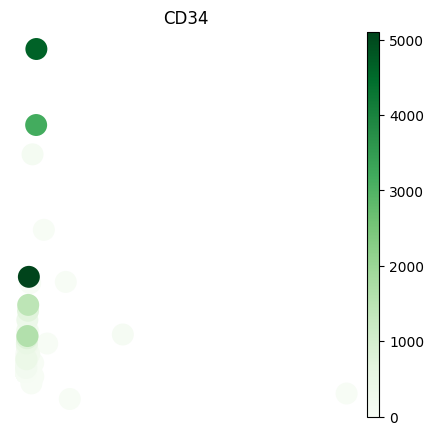

In [20]:
pca_plot_marker(adata=adata, marker='CD34')

# Analysis: Differential Expression

In [64]:
def pydeseq2_1_vs_rest(adata, lineage, reference):
    
    
    adata.obs['Lineage'] = ['Other' if x != reference else reference for x in adata.obs['Lineage']]
    
    dds = DeseqDataSet(
        adata=adata,
        ref_level=[lineage, 'Other'],
        design_factors=lineage,
        refit_cooks=True,
        n_cpus=1,
    )
    
    dds.deseq2()
    
    stat_res = DeseqStats(dds,
                    contrast=[lineage, 'Other', reference, ])
    
    stat_res.summary()
    
    stat_res.lfc_shrink(coeff="Lineage_" + reference + "_vs_Other")
    
    return stat_res.results_df

In [65]:
test = pydeseq2_1_vs_rest(adata, lineage='Lineage', reference='HSC-MPP')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.51 seconds.

Fitting dispersion trend curve...
/Users/davidchen/opt/anaconda3/lib/python3.9/site-packages/pydeseq2/dds.py:590: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend()
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 1.64 seconds.

Fitting LFCs...
... done in 1.90 seconds.

Replacing 119 outlier genes.

Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Running Wald tests...
... done in 0.11 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: Lineage Other vs HSC-MPP
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CD9       8.602165        0.317646  0.788843  0.402673  0.687189  0.823526
SLITRK6   0.130688        0.794990  3.735760  0.212805  0.831479       NaN
SPAG16    2.875521       -0.891891  0.779660 -1.143948  0.252645  0.498229
MRPL42   30.686857        0.328847  0.515274  0.638197  0.523345  0.706260
PTK2B    12.150905        0.814561  0.451567  1.803855  0.071254  0.248770
...            ...             ...       ...       ...       ...       ...
TCAF2     0.420377        0.124981  1.003044  0.124602  0.900839       NaN
UBE2C    20.521170        5.444011  1.319556  4.125639  0.000037  0.004445
ZSCAN22   0.639825        1.438826  1.060947  1.356171  0.175045       NaN
GABRA1    0.003290        0.630243  5.208438  0.121004  0.903688       NaN
RAPSN     0.042948        0.773843  1.634078  0.473565  0.635810       NaN

[1526 rows x 6 columns]


/Users/davidchen/opt/anaconda3/lib/python3.9/site-packages/pydeseq2/utils.py:1249: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/Users/davidchen/opt/anaconda3/lib/python3.9/site-packages/pydeseq2/utils.py:1249: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: Lineage HSC-MPP vs Other
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CD9       8.602165   -4.838654e-07  0.001059  0.402673  0.687189  0.823526
SLITRK6   0.130688   -9.817198e-08  0.001034  0.212805  0.831479       NaN
SPAG16    2.875521    2.237401e-06  0.001112 -1.143948  0.252645  0.498229
MRPL42   30.686857   -1.099373e-06  0.001060  0.638197  0.523345  0.706260
PTK2B    12.150905   -3.518101e-06  0.001051  1.803855  0.071254  0.248770
...            ...             ...       ...       ...       ...       ...
TCAF2     0.420377    5.912292e-07  0.001089  0.124602  0.900839       NaN
UBE2C    20.521170   -1.384075e-06  0.001022  4.125639  0.000037  0.004445
ZSCAN22   0.639825   -1.352196e-06  0.001042  1.356171  0.175045       NaN
GABRA1    0.003290   -2.504071e-08  0.001044  0.121004  0.903688       NaN
RAPSN     0.042948   -4.007867e-07  0.001034  0.473565  0.635810       NaN

[1526 rows x 6 columns]


/Users/davidchen/opt/anaconda3/lib/python3.9/site-packages/pydeseq2/utils.py:1249: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 0.67 seconds.



In [ ]:
def pydeseq2_1_vs_rest_wrapper(adata, lineage):
    
    lineage_set = list(set(adata.obs['Lineage']))
    
    deseq_dict = {}
    
    for reference in lineage_set:
        
        test_adata = adata.copy()
        
        test_adata.obs['Lineage'] = ['Other' if x != reference else reference for x in test_adata.obs['Lineage']]

        dds = DeseqDataSet(
            adata=test_adata,
            ref_level=[lineage, 'Other'],
            design_factors=lineage,
            refit_cooks=True,
            n_cpus=1,
        )

        dds.deseq2()

        stat_res = DeseqStats(dds,
                        contrast=[lineage, 'Other', reference, ])

        stat_res.summary()

        stat_res.lfc_shrink(coeff="Lineage_" + reference + "_vs_Other")
        
        deseq_dict[reference] = stat_res.results_df
        

# Analysis: WilcoxAUC

In [69]:
def get_expr(adata, layer=None):
    """Get expression matrix from adata object"""

    if layer is not None:
        x = adata.layers[layer]
    else:
        x = adata.raw.X
        
    if hasattr(x, "todense"):
        expr = jnp.asarray(x.todense())
    else:
        expr = jnp.asarray(x)

    return expr

def jit_auroc(x, groups):

    # sort scores and corresponding truth values
    desc_score_indices = jnp.argsort(x)[::-1]
    x = x[desc_score_indices]
    groups = groups[desc_score_indices]

    # x typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = jnp.array(jnp.diff(x) != 0, dtype=jnp.int32)
    threshold_mask = jnp.r_[distinct_value_indices, 1]

    # accumulate the true positives with decreasing threshold
    tps_ = jnp.cumsum(groups)
    fps_ = 1 + jnp.arange(groups.size) - tps_

    # mask out the values that are not distinct
    tps = jnp.sort(tps_ * threshold_mask)
    fps = jnp.sort(fps_ * threshold_mask)
    tps = jnp.r_[0, tps]
    fps = jnp.r_[0, fps]
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]
    area = jnp.trapz(tpr, fpr)
    return area

vmap_auroc = jax.vmap(jit_auroc, in_axes=[1, None])

def expr_auroc_over_groups(expr, uni_groups, groups):
    """Computes AUROC for each group separately."""
    auroc = np.zeros((len(uni_groups), expr.shape[1]))

    for i, group in enumerate(uni_groups):
        auroc[i, :] = np.array(vmap_auroc(expr, groups == np.array([group])))

    return auroc

def wilcoxauc(adata, group_name, layer=None):
    expr = get_expr(adata, layer=layer)

    groups = adata.obs[group_name].tolist()
    uni_groups = adata.obs[group_name].unique()

    auroc = expr_auroc_over_groups(expr, uni_groups, groups)

    if layer is not None:
        features = adata.var.index
        sc.tl.rank_genes_groups(adata, group_name, layer=layer, use_raw=False,
                        method='wilcoxon', key_added = "wilcoxon")

    else:
        features = adata.raw.var.index
        sc.tl.rank_genes_groups(adata, group_name, 
                                method='wilcoxon', key_added = "wilcoxon")

    auroc_df = pd.DataFrame(auroc).T
    auroc_df.index = features
    auroc_df.columns = uni_groups

    res=pd.DataFrame()
    for group in uni_groups:
        cstast = sc.get.rank_genes_groups_df(adata, group=group, key='wilcoxon')
        cauc = pd.DataFrame(auroc_df[group]).reset_index().rename(columns={'index':'names', group:'auc'})
        cres = pd.merge(cstast, cauc, on='names')
        cres['group']=group
        res = pd.concat([res, cres])
        
    res = res.reset_index(drop=True)
    
    return res

NameError: name 'jax' is not defined

# Analysis: SHAP

In [66]:
def shap_analysis(adata, lineage, model=xgboost.XGBClassifier()):

    X = adata.to_df()

    le = LabelEncoder()
    y = le.fit_transform(adata.obs[lineage]) 


    mapping = dict(zip(le.classes_, range(len(le.classes_))))

    model = model.fit(X, y)
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    shap_dict = {}
    for x in mapping.keys():
        output_df = pd.DataFrame(index = adata.obs.index,
                 columns = adata.var.index,
                 data = shap_values[mapping[x]])

        shap_dict[x] = output_df

    return shap_dict

In [67]:
shap_values = shap_analysis(adata=adata, lineage='Lineage', model=xgboost.XGBClassifier())

# Visualization: SHAP Summary Plot

In [73]:
def shap_summary_plot(adata, shap_values, lineage, max_display=20, cmap='RdBu_r'):
    shap.summary_plot(np.array(shap_values['HSC_MPP']), adata.to_df(), max_display=20, cmap=cmap, 
                  color_bar_label='Gene Expression')

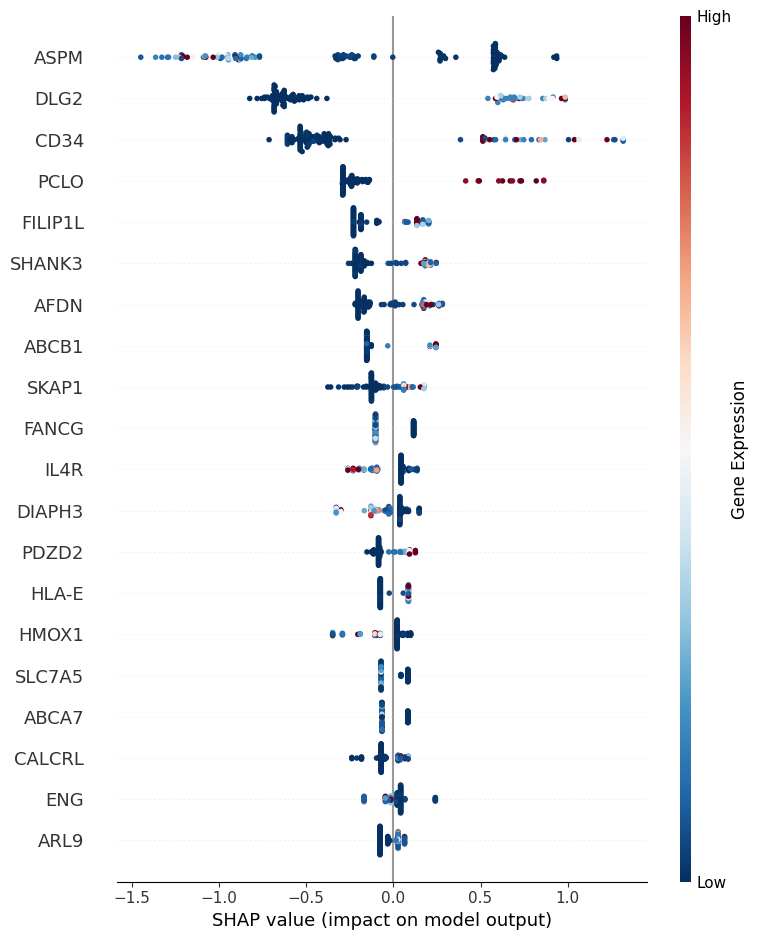

In [72]:
shap_summary_plot(adata=adata,
                  shap_values=shap_values,
                 lineage='HSC_MPP')

# Visualization: SHAP Dependency Plot

In [80]:
def shap_dependency_plot(adata, shap_values, lineage, marker, reference, max_display=20, cmap='RdBu_r'):
    
    shap_figure = shap.dependence_plot(marker, np.array(shap_values[lineage]), adata.to_df(), interaction_index=reference, cmap=cmap, show=False)
    
    # Get the current figure and axes objects. from @GarrettCGraham code
    fig, ax = plt.gcf(), plt.gca()

    # Modifying main plot parameters
    ax.tick_params(labelsize=15)
    ax.set_ylabel(marker+" SHAP", fontsize=20)
    ax.set_xlabel(marker+" Gene Expression", fontsize=20)

    # Get colorbar
    cb_ax = fig.axes[1] 

    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel(reference + " Gene Expression", fontsize=20)

    plt.show()

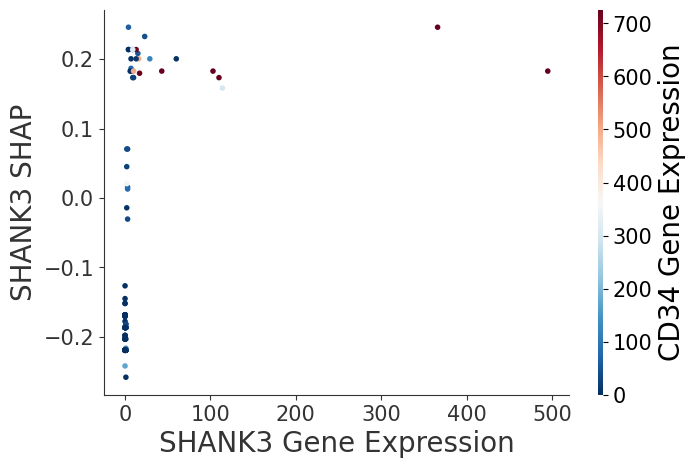

In [81]:
shap_dependency_plot(adata=adata, 
                     shap_values=shap_values, 
                     lineage='HSC_MPP', 
                     marker='SHANK3', 
                     reference='CD34')